## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Маркин Денис ML-21

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:07<00:00, 1.29MB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 207kB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:05<00:00, 275kB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

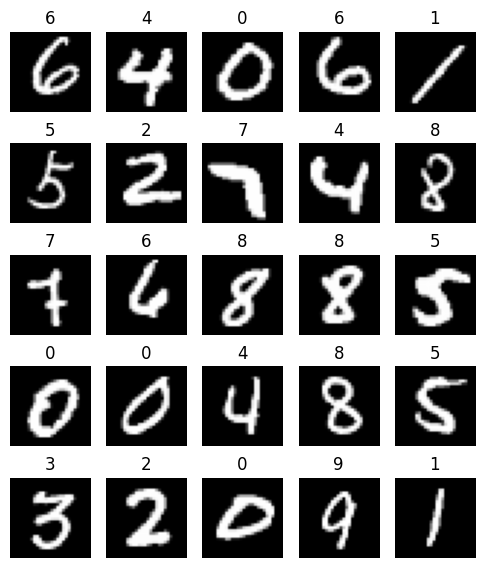

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [12]:
def init_xavier(layer):
    fan_in = layer.in_features
    fan_out = layer.out_features
    a = (6.0 / (fan_in + fan_out)) ** 0.5
    nn.init.uniform_(layer.weight, -a, a)
    if layer.bias is not None:
        nn.init.zeros_(layer.bias)

def init_he(layer, mean=0, std=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [13]:
layer_1_he = nn.Linear(28*28, 500)
layer_2_he = nn.Linear(500, 10)

layer_1_he.register_forward_hook(forward_hook)
layer_2_he.register_forward_hook(forward_hook)

layer_1_he.register_backward_hook(backward_hook)
layer_2_he.register_backward_hook(backward_hook)

init_he(layer_1_he)
init_he(layer_2_he)

layer_1_xav = nn.Linear(28*28, 500)
layer_2_xav = nn.Linear(500, 10)

layer_1_xav.register_forward_hook(forward_hook)
layer_2_xav.register_forward_hook(forward_hook)

layer_1_xav.register_backward_hook(backward_hook)
layer_2_xav.register_backward_hook(backward_hook)

init_xavier(layer_1_xav)
init_xavier(layer_2_xav)

Соберем все вместе, используя ReLU/Tanh в качестве функции активации:

In [21]:
net_he = nn.Sequential(
    layer_1_he,
    nn.ReLU(),
    layer_2_he
)

net_xav = nn.Sequential(
    layer_1_xav,
    nn.Tanh(),
    layer_2_xav
)


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

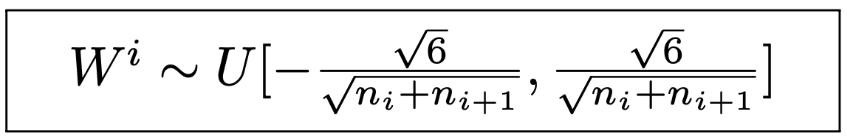

In [22]:

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data

he_activations = net_he(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(he_activations, y)
loss.backward()

print("================================")

xav_activations = net_xav(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(xav_activations, y)
loss.backward()



forward 0.9846500158309937
forward 16.572999954223633
backward 0.027888664975762367
backward 0.18684269487857819
forward 0.9846500158309937
forward 0.6471632122993469
backward 0.027888664975762367
backward 0.012526809237897396


He + ReLU приводит к взрыву активаций (std ≈ 16.6),это может вызывать нестабильность при обучении, несмотря на то, что градиенты ещё доходят до предыдущих слоёв
Xavier + Tanh в совю очередь обеспечивают умеренные и стабильные активации (std ≈ 0.65) . Градиенты остаются в разумных пределах, что создаёт лучшие, чем в прошлом случае,  условия для эффективного обучения

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

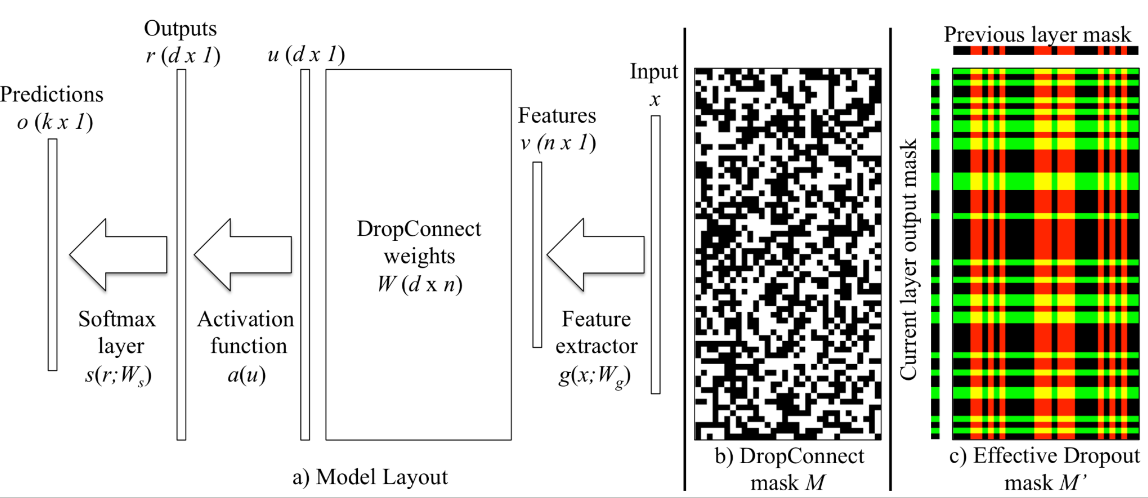

In [28]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty_like(self.linear.weight).bernoulli_(1 - self.p)
            mask.requires_grad = False
            masked_weight = self.linear.weight * mask / (1 - self.p) # Ради сохранения ожидаемого значенияя
        else:
            masked_weight = self.linear.weight

        return F.linear(x, masked_weight, self.linear.bias)

Основа для сети, которую будем обучать:

In [29]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [67]:
layers_dropout = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),          
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),          
    nn.Linear(128, 10)
]

layers_dropconnect = [
    DropConnect(196, 128, p=0.5),  
    nn.ReLU(),
    DropConnect(128, 128, p=0.5),  
    nn.ReLU(),
]

In [31]:
net_dropout = TestNetwork(nn.Sequential(*layers_dropout))
net_dropconnect = TestNetwork(nn.Sequential(*layers_dropconnect))

optimizer_dropout = torch.optim.Adam(net_dropout.parameters(), lr=0.001)
optimizer_dropconnect = torch.optim.Adam(net_dropconnect.parameters(), lr=0.001)

loss_fn = nn.NLLLoss()

Обучим получившуюся сеть:

In [63]:
def train(network, optimizer, train_loader, test_loader):
    train_losses, val_losses, val_accuracies = [], [], []
    
    for epoch in range(20):
        network.train()
        
        for batch_idx, (images_train, labels_train) in enumerate(train_loader):
            optimizer.zero_grad()
            
            output = network(images_train)
            loss = loss_fn(output, labels_train)
            loss.backward()
            optimizer.step()
            
    
        network.eval()
        
        val_loss = 0.0
        correct = 0
        total = 0
        num_val_batches = 0
        with torch.no_grad():
            for batch_idx, (images_test, labels_test) in enumerate(test_loader):
                output = network(images_test)
                loss = loss_fn(output, labels_test)
                
                val_loss += loss.item()
                num_val_batches += 1
                
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels_test.view_as(pred)).sum().item()
                total += labels_test.size(0)
    
        avg_val_loss = val_loss / num_val_batches
        val_accuracy = correct / total
        
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print('Val Epoch: {}\tLoss: {:.6f}\tAccuracy: {:.4f}'.format(
            epoch, avg_val_loss, val_accuracy))

    return val_losses, val_accuracies


In [64]:
losses_do, accs_do = train(net_dropout, optimizer_dropout, train_loader, test_loader)
losses_dc, accs_dc = train(net_dropconnect, optimizer_dropconnect, train_loader, test_loader)

Val Epoch: 0	Loss: 0.051777	Accuracy: 0.9830
Val Epoch: 1	Loss: 0.054049	Accuracy: 0.9833
Val Epoch: 2	Loss: 0.052098	Accuracy: 0.9833
Val Epoch: 3	Loss: 0.048089	Accuracy: 0.9851
Val Epoch: 4	Loss: 0.052404	Accuracy: 0.9846
Val Epoch: 5	Loss: 0.050205	Accuracy: 0.9849
Val Epoch: 6	Loss: 0.051966	Accuracy: 0.9835
Val Epoch: 7	Loss: 0.050629	Accuracy: 0.9843
Val Epoch: 8	Loss: 0.050359	Accuracy: 0.9842
Val Epoch: 9	Loss: 0.051818	Accuracy: 0.9837
Val Epoch: 10	Loss: 0.050565	Accuracy: 0.9839
Val Epoch: 11	Loss: 0.051801	Accuracy: 0.9847
Val Epoch: 12	Loss: 0.051073	Accuracy: 0.9848
Val Epoch: 13	Loss: 0.051431	Accuracy: 0.9854
Val Epoch: 14	Loss: 0.051578	Accuracy: 0.9844
Val Epoch: 15	Loss: 0.047844	Accuracy: 0.9854
Val Epoch: 16	Loss: 0.054649	Accuracy: 0.9839
Val Epoch: 17	Loss: 0.049027	Accuracy: 0.9845
Val Epoch: 18	Loss: 0.048830	Accuracy: 0.9837
Val Epoch: 19	Loss: 0.051217	Accuracy: 0.9849
Val Epoch: 0	Loss: 0.057371	Accuracy: 0.9810
Val Epoch: 1	Loss: 0.054060	Accuracy: 0.9827



#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [72]:
def draw_results(losses1, losses2, accs1, accs2):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses1, label='Dropout')
    plt.plot(losses2, label='DropConnect')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accs1, label='Dropout')
    plt.plot(accs2, label='DropConnect')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

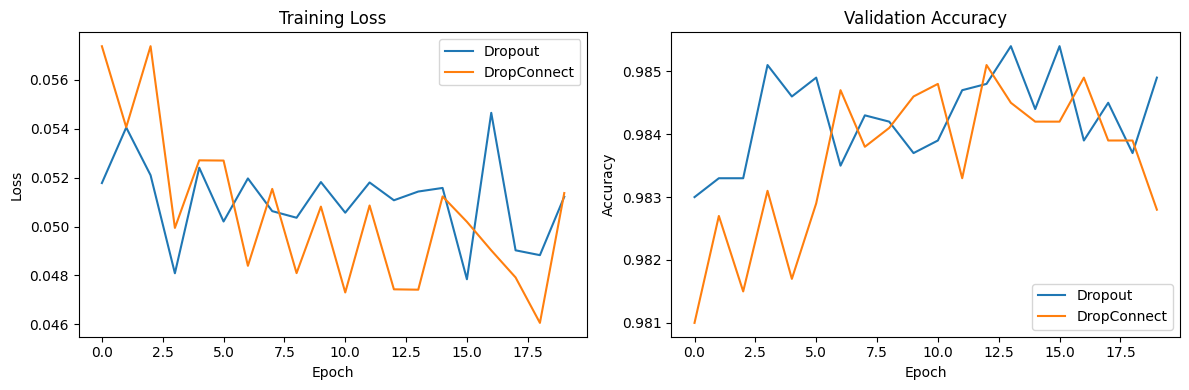

In [73]:
draw_results(losses_do, losses_dc, accs_do, accs_dc)

Dropout показывает лучшую стабильность и конечную точность
DropConnect демонстрирует потенциал (0.985 и выше было), но неустойчив — может "перепрыгнуть" оптимум

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

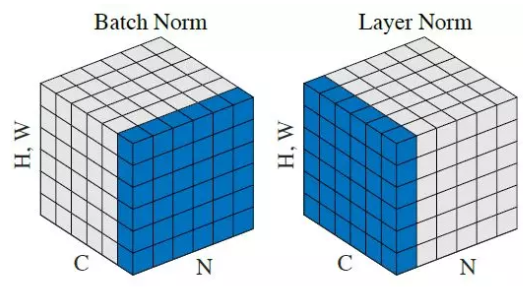

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [96]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, unbiased=False, keepdim=True)
        output = self.gamma * (x - mean) / (std + self.eps) + self.beta
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [111]:
layers_batchN = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),   
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),   
    nn.ReLU(),
    nn.Linear(128, 10)
]

layers_layerN = [
    nn.Linear(196, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]


In [112]:
net_batchN = TestNetwork(nn.Sequential(*layers_batchN))
net_layerN = TestNetwork(nn.Sequential(*layers_layerN))


optimizer_batchN = torch.optim.Adam(net_batchN.parameters(), lr=0.01)
optimizer_layerN = torch.optim.Adam(net_layerN.parameters(), lr=0.01)

loss_fn = nn.NLLLoss()

In [113]:
losses_bn, accs_bn = train(net_batchN, optimizer_batchN, train_loader, test_loader) 
losses_ln, accs_ln = train(net_layerN, optimizer_layerN, train_loader, test_loader)

Val Epoch: 0	Loss: 0.072037	Accuracy: 0.9755
Val Epoch: 1	Loss: 0.065220	Accuracy: 0.9788
Val Epoch: 2	Loss: 0.056971	Accuracy: 0.9807
Val Epoch: 3	Loss: 0.058412	Accuracy: 0.9806
Val Epoch: 4	Loss: 0.061560	Accuracy: 0.9812
Val Epoch: 5	Loss: 0.051663	Accuracy: 0.9840
Val Epoch: 6	Loss: 0.057227	Accuracy: 0.9827
Val Epoch: 7	Loss: 0.050109	Accuracy: 0.9842
Val Epoch: 8	Loss: 0.054381	Accuracy: 0.9836
Val Epoch: 9	Loss: 0.059940	Accuracy: 0.9811
Val Epoch: 10	Loss: 0.057769	Accuracy: 0.9822
Val Epoch: 11	Loss: 0.071415	Accuracy: 0.9788
Val Epoch: 12	Loss: 0.054939	Accuracy: 0.9843
Val Epoch: 13	Loss: 0.064431	Accuracy: 0.9844
Val Epoch: 14	Loss: 0.052013	Accuracy: 0.9841
Val Epoch: 15	Loss: 0.055069	Accuracy: 0.9841
Val Epoch: 16	Loss: 0.058457	Accuracy: 0.9843
Val Epoch: 17	Loss: 0.055678	Accuracy: 0.9851
Val Epoch: 18	Loss: 0.057720	Accuracy: 0.9844
Val Epoch: 19	Loss: 0.060165	Accuracy: 0.9838
Val Epoch: 0	Loss: 0.099790	Accuracy: 0.9656
Val Epoch: 1	Loss: 0.076085	Accuracy: 0.9752


In [114]:
def draw_results2(losses1, losses2, accs1, accs2):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses1, label='Batch')
    plt.plot(losses2, label='Layer')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accs1, label='Batch')
    plt.plot(accs2, label='Layer')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

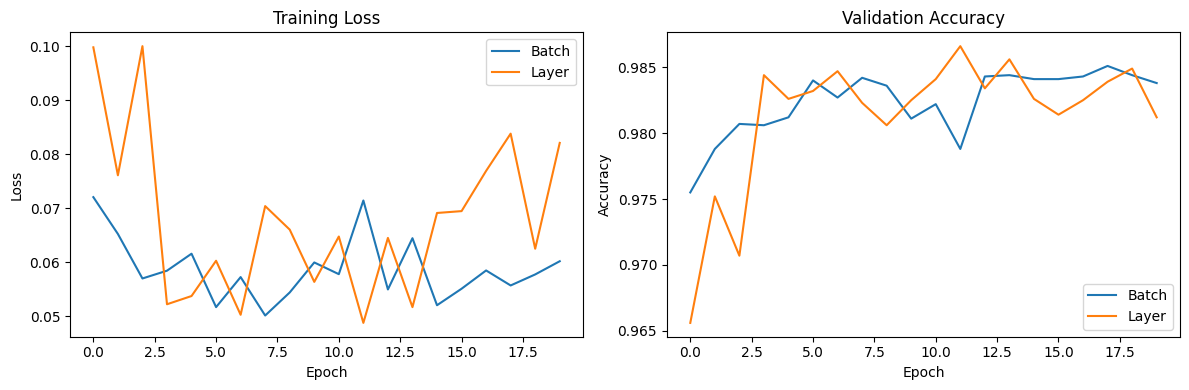

In [115]:
draw_results2(losses_bn, losses_ln, accs_bn, accs_ln)

BatchNormalization это надёжный и предсказуемый выбор, лосс не скачет и в целом стабилен
LayerNormalization это достойная альтернатива, особенно когда размер батча мал или вдруг нужна независимость от него
При этом мы видим, что обе нормализации эффективно работают в данной задаче